In [5]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import json
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [6]:
# Paths
objects_dir = "Objects"
splits_dir = "Splits"
train_dir = os.path.join(splits_dir, "train")
test_dir = os.path.join(splits_dir, "test")
val_dir = os.path.join(splits_dir, "validation")

In [7]:
# Create Splits directory if not exists
if not os.path.exists(splits_dir):
    os.makedirs(splits_dir)

# Get the list of class names
class_names = os.listdir(objects_dir)

# Create train, test, validation directories
for directory in [train_dir, test_dir, val_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [8]:
# Create subdirectories for each class in train, test, validation directories
for class_name in class_names:
    for directory in [train_dir, test_dir, val_dir]:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

In [9]:
class_names = os.listdir(objects_dir)
print(class_names)

# Split data into train, test, validation sets and move videos
for class_name in class_names:
    # List videos for the current class
    class_videos = [video for video in os.listdir(os.path.join(objects_dir, class_name)) if video.endswith(".mp4")]

    # Split data into train and test sets (80% train, 20% test)
    train_videos, test_val_videos = train_test_split(class_videos, test_size=0.2, random_state=42)
    # Split remaining data into test and validation sets (50% test, 50% validation)
    test_videos, val_videos = train_test_split(test_val_videos, test_size=0.5, random_state=42)

    # Move videos to appropriate directories
    for video in train_videos:
        src = os.path.join(objects_dir, class_name, video)
        dst = os.path.join(train_dir, class_name, video)
        shutil.copy(src, dst)

    for video in test_videos:
        src = os.path.join(objects_dir, class_name, video)
        dst = os.path.join(test_dir, class_name, video)
        shutil.copy(src, dst)

    for video in val_videos:
        src = os.path.join(objects_dir, class_name, video)
        dst = os.path.join(val_dir, class_name, video)
        shutil.copy(src, dst)

['hello', 'namaste']


In [10]:

# Define the directory paths
train_videos_dir = "Splits/train"  # Update with your actual directory path
validation_videos_dir = "Splits/validation"

# Custom data generator for videos
def video_data_generator(directory, batch_size, target_size=(224, 224), shuffle=True):
    video_folders = os.listdir(directory)
    num_classes = len(video_folders)
    class_indices = {class_name: i for i, class_name in enumerate(video_folders)}

    while True:
        if shuffle:
            np.random.shuffle(video_folders)

        for class_name in video_folders:
            class_dir = os.path.join(directory, class_name)
            videos = os.listdir(class_dir)
            if shuffle:
                np.random.shuffle(videos)

            frames = []
            labels = []
            for video in videos[:batch_size // num_classes]:
                video_path = os.path.join(class_dir, video)
                frames.extend(extract_frames(video_path, target_size))
                labels.extend([class_indices[class_name]] * len(frames))

                if len(frames) >= batch_size:
                    frames = np.array(frames[:batch_size])
                    labels = np.array(labels[:batch_size])
                    yield frames, labels
                    frames = []
                    labels = []

def extract_frames(video_path, target_size):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frames.append(frame)

    cap.release()
    return frames

# Example usage:
batch_size = 32
train_generator = video_data_generator(train_videos_dir, batch_size)
validation_generator = video_data_generator(validation_videos_dir, batch_size)

# Example of using the generators for training
for i, (X_train, y_train) in enumerate(train_generator):
    # Perform training steps using X_train and y_train
    print(f"Batch {i+1}: Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
    if i == 4:  # Stop after 5 batches for demonstration
        break

for i, (X_val, y_val) in enumerate(validation_generator):
    # Perform validation steps using X_val and y_val
    print(f"Batch {i+1}: Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
    if i == 4:  # Stop after 5 batches for demonstration
        break


Batch 1: Training data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 2: Training data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 3: Training data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 4: Training data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 5: Training data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 1: Validation data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 2: Validation data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 3: Validation data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 4: Validation data shape: (32, 224, 224, 3), Labels shape: (32,)
Batch 5: Validation data shape: (32, 224, 224, 3), Labels shape: (32,)


In [11]:


# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Assuming len(class_names) gives the number of classes
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Manually count the number of samples in the training and validation sets
train_samples = sum(len(os.listdir(os.path.join(train_videos_dir, class_name))) for class_name in class_names)
validation_samples = sum(len(os.listdir(os.path.join(validation_videos_dir, class_name))) for class_name in class_names)
print(train_samples)
print(validation_samples)



32
4


In [12]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the directory paths
train_videos_dir = "Splits/train"  # Update with your actual directory path
validation_videos_dir = "Splits/validation"
test_videos_dir = "Splits/test"  # Update with your actual test directory path
class_names = sorted(os.listdir(train_videos_dir))

# Function to load and preprocess video frames
def load_video_frames(video_path, target_size=(224, 224)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Load video frames and labels for training
X_train, y_train = [], []
for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(train_videos_dir, class_name)
    for video_file in os.listdir(class_dir):
        video_path = os.path.join(class_dir, video_file)
        frames = load_video_frames(video_path)
        X_train.extend(frames)
        y_train.extend([class_idx] * len(frames))

X_train = np.array(X_train)
y_train = np.array(y_train)

# Load video frames and labels for validation
X_val, y_val = [], []
for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(validation_videos_dir, class_name)
    for video_file in os.listdir(class_dir):
        video_path = os.path.join(class_dir, video_file)
        frames = load_video_frames(video_path)
        X_val.extend(frames)
        y_val.extend([class_idx] * len(frames))

X_val = np.array(X_val)
y_val = np.array(y_val)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [13]:
epochs = 10  # You can adjust the number of epochs as needed
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=32
)



Epoch 1/10
151/151 [==============================] - 459s 3s/step - loss: 14.0991 - accuracy: 0.9619 - val_loss: 7.7652e-04 - val_accuracy: 1.0000
Epoch 2/10
151/151 [==============================] - 446s 3s/step - loss: 0.0134 - accuracy: 0.9965 - val_loss: 0.0105 - val_accuracy: 0.9934
Epoch 3/10
151/151 [==============================] - 428s 3s/step - loss: 0.0086 - accuracy: 0.9979 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 4/10
151/151 [==============================] - 312s 2s/step - loss: 0.0020 - accuracy: 0.9992 - val_loss: 0.1021 - val_accuracy: 0.9703
Epoch 5/10
151/151 [==============================] - 285s 2s/step - loss: 7.5890e-04 - accuracy: 0.9998 - val_loss: 7.2918e-07 - val_accuracy: 1.0000
Epoch 6/10
151/151 [==============================] - 284s 2s/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 5.0287e-06 - val_accuracy: 1.0000
Epoch 7/10
151/151 [==============================] - 283s 2s/step - loss: 1.1606e-04 - accuracy: 1.0000 - val_loss: 3.8882e-

In [14]:
class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
with open("class_labels.json", "w") as f:
    json.dump(class_indices, f)
print(class_indices)


{'hello': 0, 'namaste': 1}


In [15]:
# Save the trained model
model.save('my_video_model.h5')
print("Model saved successfully.")

Model saved successfully.


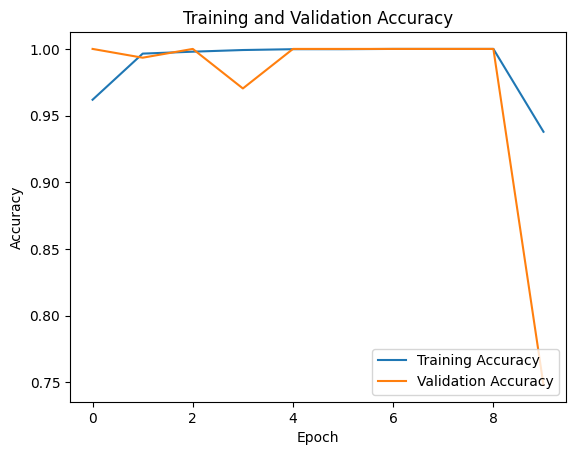

In [16]:
# Display training and validation accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

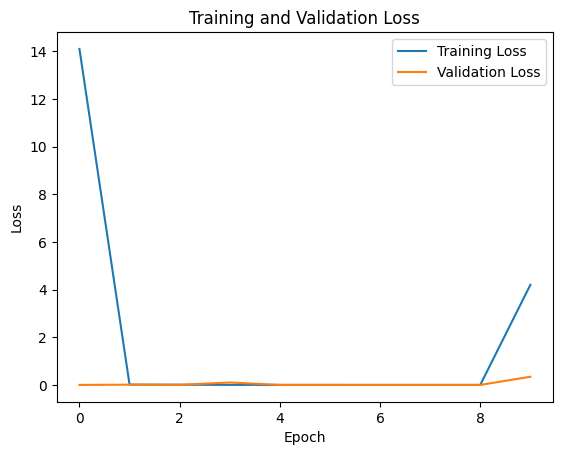

In [17]:
# Display training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [19]:
# Load the trained model
model = load_model("my_video_model.h5")

In [20]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('my_video_model.h5')

# Function to preprocess video frames for prediction
def preprocess_frame(frame, target_size=(224, 224)):
    frame = cv2.resize(frame, target_size)
    frame = frame / 255.0  # Normalize pixel values
    return frame

# Function to load and preprocess video frames from a video file
def load_and_preprocess_video(video_path, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = preprocess_frame(frame, target_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)


# Function to make predictions on video frames using the loaded model
def predict_video_frames(frames):
    # Perform prediction
    predictions = model.predict(frames)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_class_names = [class_names[idx] for idx in predicted_classes]
    return predicted_class_names

# Example of testing the model on a video
test_video_path = "video.mp4"  # Update with the path to your test video
video_frames = load_and_preprocess_video(test_video_path)
if len(video_frames) > 0:
    predicted_classes = predict_video_frames(video_frames)
    # Print the predicted classes for each frame
    print("Predicted classes for each frame:")
    print(predicted_classes)
else:
    print("Error: No frames loaded from the video.")



10/10 [==============================] - 5s 345ms/step
Predicted classes for each frame:
['hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', '

In [21]:
def load_and_preprocess_video_frames(target_size=(224, 224)):
    cap = cv2.VideoCapture(0)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Function to predict the class and confidence score for a batch of video frames
def predict_video_class(video_frames):
    predictions = model.predict(video_frames)
    class_indices = np.argmax(predictions, axis=1)  # Get the class indices for each frame
    average_confidence = np.mean(np.max(predictions, axis=1))  # Compute average confidence across frames
    return class_indices, average_confidence

# Example usage of predict_video_class function
video_path = 'Splits/train/namaste/video_9.mp4'  # Update with the actual path to your video
video_frames = load_and_preprocess_video_frames(video_path)  # Load and preprocess video frames
batch_size = len(video_frames)  # Assuming processing all frames in a single batch

# Predict class for the batch of video frames
class_indices, average_confidence = predict_video_class(video_frames)

# Print the predicted class indices for each frame
for frame_idx, class_idx in enumerate(class_indices):
    print(f"Frame {frame_idx + 1}: Predicted Class Index: {class_idx}")

# Print the average confidence score across all frames
print(f"Average Confidence Score: {average_confidence}")

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 32
>  - Can't parse 'dsize'. Expected sequence length 2, got 32


In [63]:
threshold = 0.95  # Adjust as needed

In [64]:
def detect_ood_video(video_path, threshold):
    video_frames = load_and_preprocess_video_frames(video_path)
    class_indices, average_confidence = predict_video_class(video_frames)
    
    if average_confidence < threshold:
        return True, None  # Video is OOD
    else:
        return False, class_indices[0]  # Video is in-distribution, return the class of the first frame

In [65]:
class_labels = {class_name: idx for idx, class_name in enumerate(class_names)}
print(class_labels)

{'hello': 0, 'namaste': 1}
